<a href="https://colab.research.google.com/github/byrcewang/DL_SS2H/blob/main/CIFAR_10_VGG_16_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 步骤1: 加载和预处理CIFAR-10数据集
# Define the sampling ratio
sample_ratio = 0.005  # 5% sample

# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG-16 needs 224x224 input
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load the CIFAR-10 dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Calculate the number of samples to keep
num_samples = int(sample_ratio * len(full_trainset))

# Use DataLoader with SubsetRandomSampler to create a 5% sample
subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(range(num_samples))
trainloader = torch.utils.data.DataLoader(full_trainset, batch_size=4, sampler=subset_sampler, num_workers=2)

# The rest of your code remains the same for the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 66432542.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# 步骤2: 定义VGG-16模型
vgg16 = torchvision.models.vgg16(pretrained=True)
# 冻结前面的层，只训练分类器层
for param in vgg16.features.parameters():
    param.requires_grad = False

# 修改分类器层
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 10)  # 10个类别

# 步骤3: 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9)

# 步骤4: 训练模型
vgg16.train()
for epoch in range(2):  # 仅示例中运行2个周期
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print("训练完成")

训练完成


测试准确率: 59.91%


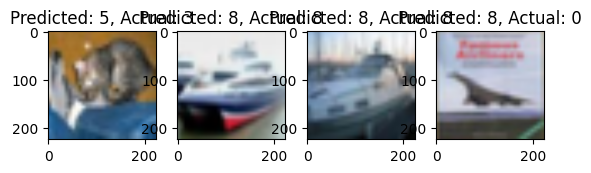

In [5]:
# 步骤5: 测试模型并可视化结果
vgg16.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'测试准确率: {100 * correct / total}%')

# 可视化测试图片和结果
images, labels = next(iter(testloader))
outputs = vgg16(images)
_, predicted = torch.max(outputs, 1)

# 可视化结果
fig, axes = plt.subplots(1, 4)
for i in range(4):
    image = images[i] / 2 + 0.5  # 反标准化
    image = image.permute(1, 2, 0)  # 通道顺序调整
    axes[i].imshow(image)
    axes[i].set_title(f'Predicted: {predicted[i]}, Actual: {labels[i]}')

plt.show()